In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random # Reproducibility
import time


In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:

PROJECT_ROOT = Path().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

csv_path = PROCESSED_DIR / "person_clean_dataset.csv"

df = pd.read_csv(csv_path)
print("Rows in dataset:", len(df))
df.head()

Rows in dataset: 1992


,image_id,image_path,XMin,XMax,YMin,YMax
0,03824eac0cc9293f,../data/raw_images/train/person/03824eac0cc929...,0.597500,0.787500,0.464167,0.666667
1,00cb2903a338b1ed,../data/raw_images/train/person/00cb2903a338b1...,0.175000,0.936875,0.115000,1.000000
2,03df3dd775f4da95,../data/raw_images/train/person/03df3dd775f4da...,0.341912,0.712010,0.098856,0.756536
3,038259d823c904fa,../data/raw_images/train/person/038259d823c904...,0.160625,0.953750,0.229462,0.999056
4,03df2f11c8dc6c6f,../data/raw_images/train/person/03df2f11c8dc6c...,0.343750,0.400000,0.719745,0.823248


In [4]:
# compute center (xc, yc) and width/height (w, h) in normalized [0,1]
df["xc"] = (df["XMin"] + df["XMax"]) / 2.0
df["yc"] = (df["YMin"] + df["YMax"]) / 2.0
df["w"]  = df["XMax"] - df["XMin"]
df["h"]  = df["YMax"] - df["YMin"]

df[["image_path", "xc", "yc", "w", "h"]].head()


,image_path,xc,yc,w,h
0,../data/raw_images/train/person/03824eac0cc929...,0.692500,0.565417,0.190000,0.202500
1,../data/raw_images/train/person/00cb2903a338b1...,0.555937,0.557500,0.761875,0.885000
2,../data/raw_images/train/person/03df3dd775f4da...,0.526961,0.427696,0.370098,0.657680
3,../data/raw_images/train/person/038259d823c904...,0.557187,0.614259,0.793125,0.769594
4,../data/raw_images/train/person/03df2f11c8dc6c...,0.371875,0.771497,0.056250,0.103503


In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

len(train_df), len(val_df)


(1593, 399)

In [6]:
class CropDataset(Dataset):
    def __init__(self, df, transform=None, image_size=224):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_size = image_size

        # basic transform if none provided
        if self.transform is None:
            self.transform = T.Compose([
                T.Resize((image_size, image_size)),
                T.ToTensor(),
                # normalize with ImageNet stats (good default)
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        img = Image.open(img_path).convert("RGB")

        # normalized target box (already [0,1])
        target = np.array([row["xc"], row["yc"], row["w"], row["h"]], dtype=np.float32)

        img = self.transform(img)
        target = torch.tensor(target, dtype=torch.float32)

        return img, target


In [7]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

train_dataset = CropDataset(train_df, image_size=IMAGE_SIZE)
val_dataset   = CropDataset(val_df, image_size=IMAGE_SIZE)

g = torch.Generator()
g.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, generator=g)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

len(train_loader), len(val_loader)


(100, 25)

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=128):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size * self.grid_size

        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)                          # (B, embed_dim, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)          # (B, num_patches, embed_dim)
        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads=4, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)

        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        # x: (B, N, D)
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out

        x_norm = self.norm2(x)
        x = x + self.mlp(x_norm)
        return x


class TinyViTBackbone(nn.Module):
    def __init__(self, img_size=224, patch_size=16, embed_dim=128, depth=2, num_heads=4):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 3, embed_dim)
        num_patches = self.patch_embed.num_patches

        # CLS token + positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads=num_heads)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        # init
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        # x: (B, 3, H, W)
        B = x.size(0)
        x = self.patch_embed(x)  # (B, N, D)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        x = torch.cat((cls_tokens, x), dim=1)          # (B, 1+N, D)

        x = x + self.pos_embed

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        cls_out = x[:, 0]   # (B, D)
        return cls_out


In [9]:
class CropRegressor(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Sigmoid(),  # keep outputs in [0,1]
        )

    def forward(self, x):
        return self.mlp(x)


class TinyViTCropModel(nn.Module):
    def __init__(self, img_size=224, patch_size=16, embed_dim=128, depth=2, num_heads=4):
        super().__init__()
        self.backbone = TinyViTBackbone(
            img_size=img_size,
            patch_size=patch_size,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
        )
        self.head = CropRegressor(embed_dim=embed_dim)

    def forward(self, x):
        feats = self.backbone(x)          # (B, D)
        pred_boxes = self.head(feats)     # (B, 4), normalized
        return pred_boxes


In [10]:
def box_xywh_to_xyxy(box):
    # box: (B, 4) [xc, yc, w, h] in [0,1]
    xc, yc, w, h = box[:, 0], box[:, 1], box[:, 2], box[:, 3]
    x1 = xc - w / 2.0
    y1 = yc - h / 2.0
    x2 = xc + w / 2.0
    y2 = yc + h / 2.0
    return torch.stack([x1, y1, x2, y2], dim=-1)


def iou_loss(pred, target):
    # pred, target: (B,4) in [0,1] as (xc,yc,w,h)
    pred_xyxy = box_xywh_to_xyxy(pred)
    tgt_xyxy  = box_xywh_to_xyxy(target)

    x1 = torch.max(pred_xyxy[:, 0], tgt_xyxy[:, 0])
    y1 = torch.max(pred_xyxy[:, 1], tgt_xyxy[:, 1])
    x2 = torch.min(pred_xyxy[:, 2], tgt_xyxy[:, 2])
    y2 = torch.min(pred_xyxy[:, 3], tgt_xyxy[:, 3])

    inter_w = (x2 - x1).clamp(min=0)
    inter_h = (y2 - y1).clamp(min=0)
    inter = inter_w * inter_h

    area_pred = (pred_xyxy[:, 2] - pred_xyxy[:, 0]).clamp(min=0) * \
                (pred_xyxy[:, 3] - pred_xyxy[:, 1]).clamp(min=0)
    area_tgt = (tgt_xyxy[:, 2] - tgt_xyxy[:, 0]).clamp(min=0) * \
               (tgt_xyxy[:, 3] - tgt_xyxy[:, 1]).clamp(min=0)

    union = area_pred + area_tgt - inter + 1e-6
    iou = inter / union
    return 1.0 - iou.mean()  # IoU loss to minimize


smooth_l1 = nn.SmoothL1Loss()


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = TinyViTCropModel(img_size=IMAGE_SIZE).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4) #lr=1e-4
num_epochs = 15  # you can increase later


Using device: cpu


In [12]:
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("Train samples:", len(train_df))
print("Val samples:", len(val_df))

Device: cpu
Train samples: 1593
Val samples: 399


In [13]:
def train_one_epoch(model, loader, optimizer, device, epoch=None):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch_idx, (imgs, targets) in enumerate(loader, start=1):
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = model(imgs)

        l1 = smooth_l1(preds, targets)
        iou = iou_loss(preds, targets)
        loss = l1 + iou

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    epoch_loss = total_loss / len(loader.dataset)
    epoch_time = time.time() - start_time
    print(f"→ Epoch {epoch} finished in {epoch_time:.2f}s | Train Loss: {epoch_loss:.4f}")
    return epoch_loss, epoch_time


@torch.no_grad()
def eval_one_epoch(model, loader, device, epoch=None):
    model.eval()
    total_loss = 0.0

    for batch_idx, (imgs, targets) in enumerate(loader, start=1):
        imgs = imgs.to(device)
        targets = targets.to(device)

        preds = model(imgs)
        l1 = smooth_l1(preds, targets)
        iou = iou_loss(preds, targets)
        loss = l1 + iou

        total_loss += loss.item() * imgs.size(0)

    epoch_loss = total_loss / len(loader.dataset)
    print(f"→ Eval Epoch {epoch} | Val Loss: {epoch_loss:.4f}")
    return epoch_loss


# MAIN TRAINING LOOP
training_log = []


for epoch in range(1, num_epochs + 1):
    train_loss, epoch_time = train_one_epoch(
        model, train_loader, optimizer, device, epoch=epoch
    )

    val_loss = eval_one_epoch(
        model, val_loader, device, epoch=epoch
    )

    training_log.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "epoch_time_sec": epoch_time,
        "learning_rate": optimizer.param_groups[0]["lr"],
    })

    print("-" * 70)

training_df = pd.DataFrame(training_log)
training_df

→ Epoch 1 finished in 40.85s | Train Loss: 0.7072
→ Eval Epoch 1 | Val Loss: 0.6668
----------------------------------------------------------------------
→ Epoch 2 finished in 38.82s | Train Loss: 0.6692
→ Eval Epoch 2 | Val Loss: 0.6489
----------------------------------------------------------------------
→ Epoch 3 finished in 37.78s | Train Loss: 0.6624
→ Eval Epoch 3 | Val Loss: 0.6460
----------------------------------------------------------------------
→ Epoch 4 finished in 37.98s | Train Loss: 0.6595
→ Eval Epoch 4 | Val Loss: 0.6458
----------------------------------------------------------------------
→ Epoch 5 finished in 39.12s | Train Loss: 0.6577
→ Eval Epoch 5 | Val Loss: 0.6445
----------------------------------------------------------------------
→ Epoch 6 finished in 39.69s | Train Loss: 0.6565
→ Eval Epoch 6 | Val Loss: 0.6430
----------------------------------------------------------------------
→ Epoch 7 finished in 38.28s | Train Loss: 0.6552
→ Eval Epoch 7 | Val

,epoch,train_loss,val_loss,epoch_time_sec,learning_rate
0,1,0.707224,0.666838,40.846921,0.00001
1,2,0.669222,0.648887,38.816262,0.00001
2,3,0.662369,0.645965,37.784472,0.00001
3,4,0.659478,0.645839,37.977780,0.00001
4,5,0.657745,0.644487,39.116039,0.00001
5,6,0.656493,0.643022,39.690570,0.00001
6,7,0.655190,0.643310,38.280708,0.00001
7,8,0.654447,0.641015,38.058831,0.00001
8,9,0.654081,0.644797,38.306539,0.00001
9,10,0.652789,0.641649,38.455453,0.00001


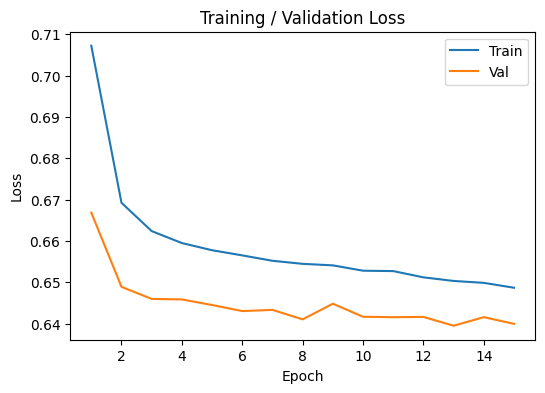

In [14]:
plt.figure(figsize=(6,4))

plt.plot(training_df["epoch"], training_df["train_loss"], label="Train")
plt.plot(training_df["epoch"], training_df["val_loss"], label="Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss")
plt.legend()
plt.show()


The supervised TinyViT crop regression model converged after fine-tuning at a learning rate of 1e-5, with stable and smoothly decreasing training and validation losses. Further training yielded diminishing returns, indicating convergence.

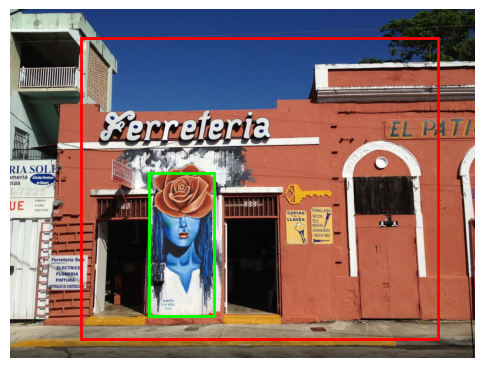

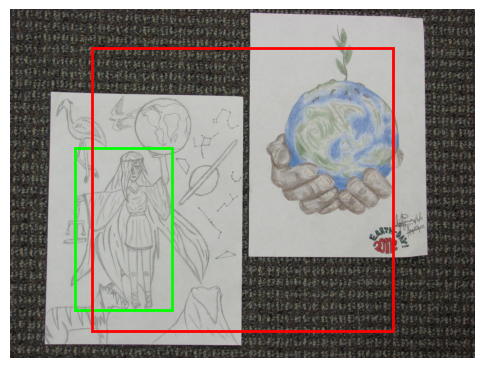

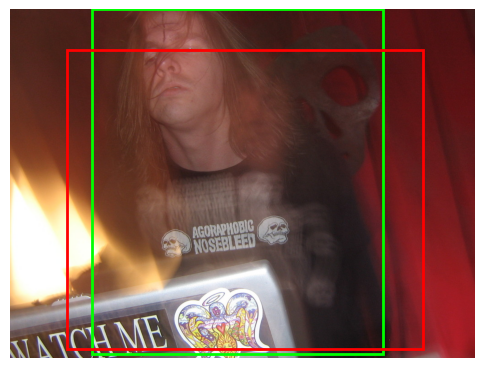

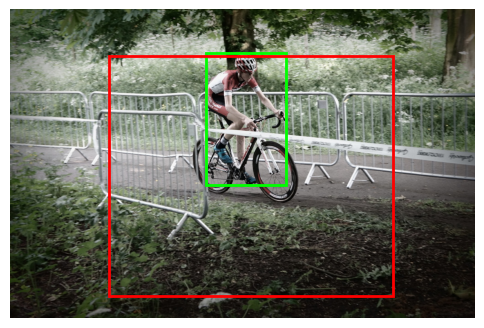

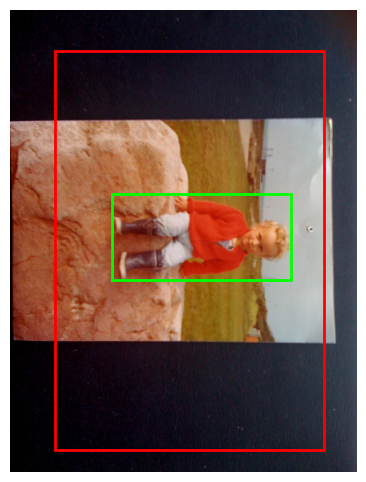

In [15]:
@torch.no_grad()
def visualize_predictions(model, df_sample, num_samples=5):
    model.eval()
    for i in range(num_samples):
        row = df_sample.sample(1).iloc[0]
        img_path = row["image_path"]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        # prepare input
        x = train_dataset.transform(img).unsqueeze(0).to(device)  # reuse transform
        pred = model(x).cpu().squeeze(0).numpy()

        # gt & pred boxes (xc,yc,w,h)
        gt = np.array([row["xc"], row["yc"], row["w"], row["h"]])

        def xywh_to_xyxy(box):
            xc, yc, bw, bh = box
            x1 = (xc - bw/2) * w
            y1 = (yc - bh/2) * h
            x2 = (xc + bw/2) * w
            y2 = (yc + bh/2) * h
            return x1, y1, x2, y2

        gt_x1, gt_y1, gt_x2, gt_y2 = xywh_to_xyxy(gt)
        pr_x1, pr_y1, pr_x2, pr_y2 = xywh_to_xyxy(pred)

        fig, ax = plt.subplots(1, figsize=(6,6))
        ax.imshow(img)

        # GT in green
        ax.add_patch(
            patches.Rectangle(
                (gt_x1, gt_y1),
                gt_x2 - gt_x1, gt_y2 - gt_y1,
                linewidth=2, edgecolor="lime", facecolor="none", label="GT"
            )
        )
        # Pred in red
        ax.add_patch(
            patches.Rectangle(
                (pr_x1, pr_y1),
                pr_x2 - pr_x1, pr_y2 - pr_y1,
                linewidth=2, edgecolor="red", facecolor="none", label="Pred"
            )
        )

        plt.axis("off")
        plt.show()


visualize_predictions(model, val_df, num_samples=5)


After convergence, the supervised TinyViT crop regression model was frozen and used as a fixed baseline for further evaluation and reinforcement learning refinement.

In [ ]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
    },"../models/tinyvit_supervised_final.pth"
)
